<a href="https://colab.research.google.com/github/ivoryRabbit/RL_examples/blob/main/A2C_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install python-opengl
!pip install pyvirtualdisplay
!apt install ffmpeg
!apt install xvfb

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform

import gym
import matplotlib.pyplot as plt

import base64
import os, io, glob

from IPython.display import HTML, display, clear_output

In [3]:
np.random.seed(777)
tf.random.set_seed(777)

In [4]:
class Actor(tf.keras.Model):
    def __init__(self, state_dim, action_dim, learning_rate, action_bound):
        super(Actor, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound

        self.latent_layer = Dense(128, activation = 'relu')
        self.mu_layer = Dense(
            self.action_dim,
            kernel_initializer = self.initializer(),
            bias_initializer = self.initializer(), 
            activation = 'tanh'
        )
        self.std_layer = Dense(
            self.action_dim,
            kernel_initializer = self.initializer(),
            bias_initializer = self.initializer(),
            activation = 'softplus'
        )
        self.actor_optimizer = Adam(lr = learning_rate)

    def call(self, inputs):
        x = self.latent_layer(inputs)
        mu = Lambda(lambda x: x*2)(self.mu_layer(x))
        std = self.std_layer(x)  
        return mu, std

    def initializer(self, bound = 3e-3):
        return RandomUniform(-bound, bound)

    def get_action(self, state, is_train = True):
        mu, std = self(state[np.newaxis, :])
        action = np.random.normal(mu[0], std[0], size = self.action_dim)
        action = np.clip(action, -self.action_bound, self.action_bound)
        return action if is_train else mu[0]

    def log_pdf(self, mu, std, action):
        log_unnormalized = -0.5 * tf.math.squared_difference(action / std, mu / std)
        log_normalization = tf.constant(0.5 * np.log(2.0 * np.pi), dtype = tf.float32) + tf.math.log(std)
        return log_unnormalized - log_normalization

    @tf.function(experimental_compile = True)
    def train_step(self, state, action, advantage):
        with tf.GradientTape() as tape:
            mu, std = self(state)
            log_policy_pdf = self.log_pdf(mu, std, action)
            loss_policy = -log_policy_pdf * advantage
            loss = tf.reduce_sum(loss_policy, axis = -1)
        dj_dtheta = tape.gradient(loss, self.trainable_variables)
        grad = zip(dj_dtheta, self.trainable_variables)
        self.actor_optimizer.apply_gradients(grad)
        return loss

In [5]:
class Critic(tf.keras.Model):
    def __init__(self, state_dim, action_dim, learning_rate):
        super(Critic, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim

        self.latent_layer = Dense(128, activation = 'relu')
        self.output_layer = Dense(
            1, 
            kernel_initializer = self.initializer(),
            bias_initializer = self.initializer(),
            activation = 'linear'
        )
        self.critic_optimizer = Adam(lr = learning_rate)

    def call(self, inputs):
        x = self.latent_layer(inputs)
        return self.output_layer(x)

    def initializer(self, bound = 3e-3):
        return RandomUniform(-bound, bound)

    @tf.function(experimental_compile = True)
    def train_step(self, state, targ_v):
        with tf.GradientTape() as tape:
            pred_v = self(state)
            loss_value = 0.5 * tf.math.squared_difference(pred_v, targ_v)
            loss = tf.reduce_sum(loss_value, axis = -1)
        dj_dtheta = tape.gradient(loss, self.trainable_variables)
        grad = zip(dj_dtheta, self.trainable_variables)
        self.critic_optimizer.apply_gradients(grad)
        return loss

In [6]:
class A2Cagent:
    def __init__(self, env, gamma):
        self.env = env
        self.gamma = gamma
        self.actor_learning_rate = 1e-4
        self.critic_learning_rate = 1e-3
        
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_bound = env.action_space.high[0]

        self.actor = Actor(
            self.state_dim, 
            self.action_dim, 
            self.actor_learning_rate,
            self.action_bound
        )
        self.critic = Critic(
            self.state_dim, 
            self.action_dim, 
            self.critic_learning_rate
        )

        self.save_reward = []
        self.save_actor_loss = []
        self.save_critic_loss = []

    def advantage_targ_v(self, reward, pred_v, next_pred_v, done):
        targ_v = reward + self.gamma * next_pred_v * (1-done)
        advantage = targ_v - pred_v
        return advantage, targ_v

    def convert_dtype(self, *args):
        f = lambda x: np.asarray([x], dtype = np.float32)
        return [f(arg) for arg in args]

    def train(self, max_epi_num):
        epi_reward, done = 0, False
        state = self.env.reset()
        for epi in range(max_epi_num):
            action = self.actor.get_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state, next_state, action = self.convert_dtype(state, next_state, action)
            advantage, targ_v = self.advantage_targ_v(
                reward = (reward+8)/8, 
                pred_v = self.critic(state), 
                next_pred_v = self.critic(next_state), 
                done = done
            )
            

            actor_loss = self.actor.train_step(state, action, advantage)
            critic_loss = self.critic.train_step(state, targ_v)
            
            self.save_actor_loss.append(actor_loss)
            self.save_critic_loss.append(critic_loss)

            state = next_state[0]
            epi_reward += reward
            
            if done:
                self.save_reward.append(epi_reward)
                self._plot(epi+1)
                print(f'Episode: [{(epi+1) // 200}], Total Step: [{epi+1}], Reward: [{epi_reward:.3f}]')

                epi_reward = 0
                state = self.env.reset()

        self.env.close()

    def test(self):        
        state = self.env.reset()
        epi_reward, done = 0, False
        frames = []
        while not done:
            frames.append(self.env.render(mode = 'rgb_array'))
            action = self.actor.get_action(state, is_train = False)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            epi_reward += reward

        print(f'Episode Reward: {epi_reward:.3f}')
        self.env.close()
        return frames

    def _plot(self, epi):
        def subplot(loc, title, values):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, 'reward', self.save_reward),
            (132, 'actor loss', self.save_actor_loss),
            (133, 'critic loss', self.save_critic_loss),
        ]
        clear_output(True)
        plt.figure(figsize = (30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [7]:
env = gym.make('Pendulum-v0')
agent = A2Cagent(env, gamma = 0.9)

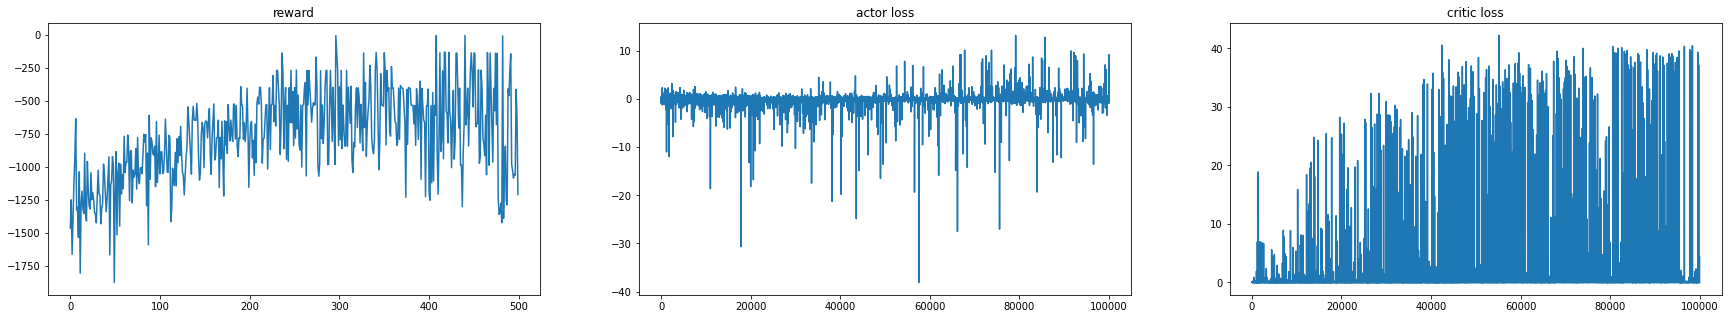

Episode: [500], Total Step: [100000], Reward: [-1209.148]


In [8]:
agent.train(max_epi_num = 100000)

In [9]:
agent.env = gym.wrappers.Monitor(agent.env, 'videos', force = True)
frames = agent.test()

Episode Reward: -138.965


In [10]:
def ipython_show_video(path):
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(
        data = """
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode('ascii'))
    ))

In [11]:
list_of_files = glob.glob('videos/*.mp4')
latest_file = max(list_of_files, key = os.path.getctime)
print(latest_file)

videos/openaigym.video.0.2719.video000000.mp4


In [12]:
ipython_show_video(latest_file)